# Proximal Policy Optimization (PPO-Clip)
### Solving `Pendulum-v1` Problem
> Deep RL course - Fall 2024 - Sharif University of Technology - Workshop session <br>
> Author: M Narimani - December 29th, 2024

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import gym

In [2]:
print("TensorFlow %s" % tf.__version__)
print("tfp %s" % tfp.__version__)
print("gym %s" % gym.__version__)
print("numpy %s" % np.__version__)

TensorFlow 2.10.0
tfp 0.18.0
gym 0.26.0
numpy 1.23.0


In [3]:
env = gym.make('Pendulum-v1')
S_DIM = env.observation_space.shape[0]
A_DIM = env.action_space.shape[0]
A_BOUND = [env.action_space.low[0], env.action_space.high[0]]

In [4]:
EP_MAX = 2000
EP_LEN = 200
GAMMA = 0.9
A_LR = 0.0001
C_LR = 0.0005
BATCH = 64
A_UPDATE_STEPS = 10
C_UPDATE_STEPS = 10
EPSILON = 0.2 # Clipped surrogate objective

## PPO algorithm

<center>
<img src="ppo-dong.png" alt="PPO" width=500/>
</center>

In [5]:
class ActorNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.mu = tf.keras.layers.Dense(A_DIM, activation='tanh')
        self.sigma = tf.keras.layers.Dense(A_DIM, activation='softplus')
        
    def call(self, state):
        x = self.dense1(state)
        mu = self.mu(x) * A_BOUND[1]
        sigma = self.sigma(x)
        return mu, sigma + 1e-4

In [6]:
class CriticNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.value = tf.keras.layers.Dense(1)
        
    def call(self, state):
        x = self.dense1(state)
        return self.value(x)

In [7]:
class PPO:
    def __init__(self):
        self.actor = ActorNetwork()
        self.actor_old = ActorNetwork()
        self.critic = CriticNetwork()
        
        # Build models with dummy input
        dummy_state = tf.random.normal((1, S_DIM))
        self.actor(dummy_state)
        self.actor_old(dummy_state)
        self.critic(dummy_state)
        
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=A_LR)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=C_LR)
        
        # Add metrics tracking
        self.actor_loss_metric = tf.keras.metrics.Mean('actor_loss', dtype=tf.float32)
        self.critic_loss_metric = tf.keras.metrics.Mean('critic_loss', dtype=tf.float32)

    def update_old_actor(self):
        self.actor_old.set_weights(self.actor.get_weights())

    @tf.function
    def choose_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        mu, sigma = self.actor(state)
        dist = tf.random.normal(shape=mu.shape)
        action = mu + sigma * dist
        return tf.clip_by_value(action[0], A_BOUND[0], A_BOUND[1])

    @tf.function
    def get_value(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        return self.critic(state)[0, 0]

    @tf.function
    def actor_loss(self, states, actions, advantages):
        mu, sigma = self.actor(states)
        old_mu, old_sigma = self.actor_old(states)
        
        # Calculate probabilities
        dist = tfp.distributions.Normal(mu, sigma)
        old_dist = tfp.distributions.Normal(old_mu, old_sigma)
        
        ratio = tf.exp(dist.log_prob(actions) - old_dist.log_prob(actions))
        surr = ratio * advantages
        
        # Clipped surrogate objective
        clip_surr = tf.clip_by_value(ratio, 1.-EPSILON, 1.+EPSILON) * advantages
        
        return -tf.reduce_mean(tf.minimum(surr, clip_surr))

    @tf.function
    def critic_loss(self, states, discounted_rewards):
        values = self.critic(states)
        return tf.reduce_mean(tf.square(discounted_rewards - values))

    @tf.function
    def train_actor(self, states, actions, advantages):
        with tf.GradientTape() as tape:
            loss = self.actor_loss(states, actions, advantages)
        grads = tape.gradient(loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(grads, self.actor.trainable_variables))
        self.actor_loss_metric.update_state(loss)
        return loss

    @tf.function
    def train_critic(self, states, discounted_rewards):
        with tf.GradientTape() as tape:
            loss = self.critic_loss(states, discounted_rewards)
        grads = tape.gradient(loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
        self.critic_loss_metric.update_state(loss)
        return loss

    def update(self, states, actions, rewards):
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        
        # Reset metrics
        self.actor_loss_metric.reset_states()
        self.critic_loss_metric.reset_states()
        
        # Calculate advantage
        values = self.critic(states)
        advantages = rewards - values
        
        # Update old actor
        self.update_old_actor()
        
        # Update actor
        for _ in range(A_UPDATE_STEPS):
            self.train_actor(states, actions, advantages)
            
        # Update critic
        for _ in range(C_UPDATE_STEPS):
            self.train_critic(states, rewards)
            
        # Return the average losses
        return {
            'actor_loss': self.actor_loss_metric.result().numpy(),
            'critic_loss': self.critic_loss_metric.result().numpy()
        }

## Main

In [8]:
%%time

ppo = PPO()
all_ep_r = []
all_actor_losses = []
all_critic_losses = []

for ep in range(EP_MAX):
    s = env.reset()[0]
    buffer_s, buffer_a, buffer_r = [], [], []
    ep_r = 0
    ep_actor_losses = []
    ep_critic_losses = []
    
    for t in range(EP_LEN):
        a = ppo.choose_action(s).numpy()
        s_, r, terminated, truncated, _ = env.step(a)
        
        buffer_s.append(s)
        buffer_a.append(a)
        buffer_r.append(r)
        
        s = s_
        ep_r += r

        # update ppo
        if (t + 1) % BATCH == 0 or t == EP_LEN - 1:
            v_s_ = ppo.get_value(s_).numpy()
            discounted_r = []
            for r in buffer_r[::-1]:
                v_s_ = r + GAMMA * v_s_
                discounted_r.append(v_s_)
            discounted_r.reverse()

            bs = np.vstack(buffer_s)
            ba = np.vstack(buffer_a)
            br = np.array(discounted_r)[:, np.newaxis]
            
            losses = ppo.update(bs, ba, br)
            ep_actor_losses.append(losses['actor_loss'])
            ep_critic_losses.append(losses['critic_loss'])
            buffer_s, buffer_a, buffer_r = [], [], []


    all_ep_r.append(ep_r)
    avg_score = np.mean(all_ep_r[-100:])
    
    avg_actor_loss = np.mean(ep_actor_losses) if ep_actor_losses else 0
    avg_critic_loss = np.mean(ep_critic_losses) if ep_critic_losses else 0
    all_actor_losses.append(avg_actor_loss)
    all_critic_losses.append(avg_critic_loss)

    if (ep+1) % 10 == 0:
        print(f"Episode: {ep+1:4d} | "
              f"Score: {int(ep_r):5d} | "
              f"Avg Score: {int(avg_score):5d} | "
              f"Actor Loss: {avg_actor_loss:.2f} | "
              f"Critic Loss: {avg_critic_loss:.2f}")

    # Check if solved
    if len(all_ep_r) >= 100 and avg_score >= -300:
        print(f'Problem solved in {ep+1} episodes')
        break

Episode:   10 | Score: -1532 | Avg Score: -1446 | Actor Loss: 45.65 | Critic Loss: 2397.85
Episode:   20 | Score: -1407 | Avg Score: -1420 | Actor Loss: 23.02 | Critic Loss: 669.19
Episode:   30 | Score: -1317 | Avg Score: -1400 | Actor Loss: 2.93 | Critic Loss: 321.37
Episode:   40 | Score: -1323 | Avg Score: -1370 | Actor Loss: 5.58 | Critic Loss: 134.72
Episode:   50 | Score: -1367 | Avg Score: -1362 | Actor Loss: 1.36 | Critic Loss: 44.74
Episode:   60 | Score: -1075 | Avg Score: -1339 | Actor Loss: -0.74 | Critic Loss: 70.79
Episode:   70 | Score: -1114 | Avg Score: -1327 | Actor Loss: 0.89 | Critic Loss: 56.74
Episode:   80 | Score: -1389 | Avg Score: -1319 | Actor Loss: 2.27 | Critic Loss: 21.83
Episode:   90 | Score: -1187 | Avg Score: -1320 | Actor Loss: -3.67 | Critic Loss: 28.62
Episode:  100 | Score: -1558 | Avg Score: -1313 | Actor Loss: 3.65 | Critic Loss: 24.00
Episode:  110 | Score: -1063 | Avg Score: -1295 | Actor Loss: 2.16 | Critic Loss: 47.48
Episode:  120 | Score: 

# Results
## Learning curves

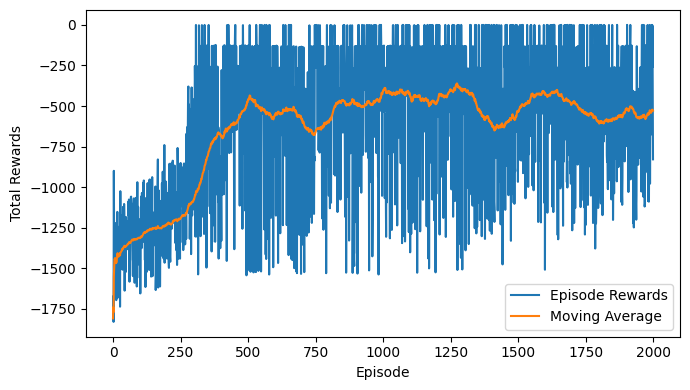

In [9]:
def running_avg(totalrewards):
    N = len(totalrewards)
    totalrewards = np.array(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    return running_avg

plt.figure(figsize=(7, 4))
plt.plot(all_ep_r, label='Episode Rewards')
plt.plot(running_avg(all_ep_r), label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.legend()
plt.tight_layout()
plt.show()

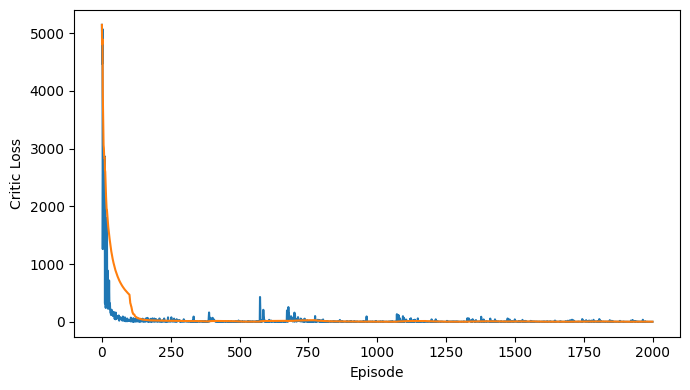

In [10]:
plt.figure(figsize=(7, 4))
plt.plot(all_critic_losses)
plt.plot(running_avg(np.array(all_critic_losses)))
plt.xlabel('Episode')
plt.ylabel('Critic Loss')
plt.tight_layout()
plt.show()

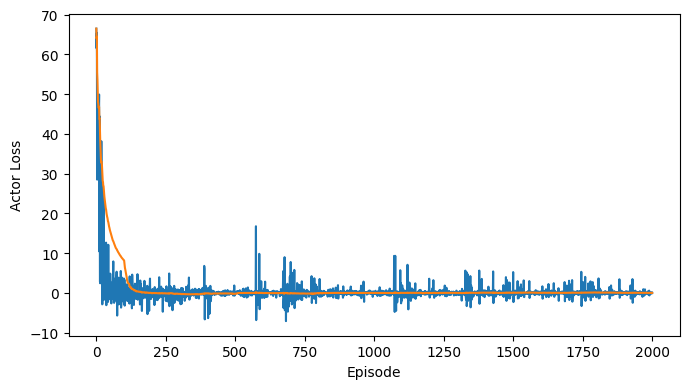

In [11]:
plt.figure(figsize=(7, 4))
plt.plot(all_actor_losses)
plt.plot(running_avg(np.array(all_actor_losses)))
plt.xlabel('Episode')
plt.ylabel('Actor Loss')
plt.tight_layout()
plt.show()

## Cost-to-go

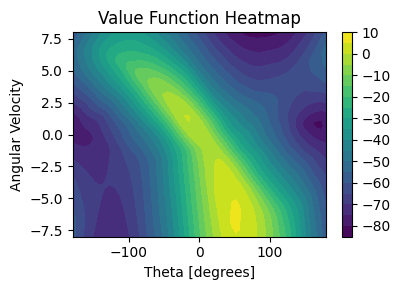

In [12]:
# TODO

## Policy map

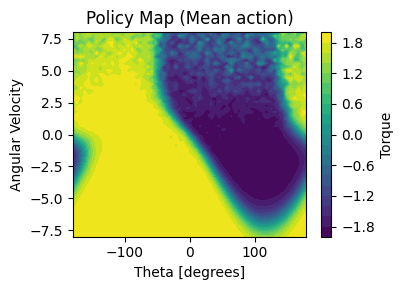

In [13]:
# TODO

## State histogram

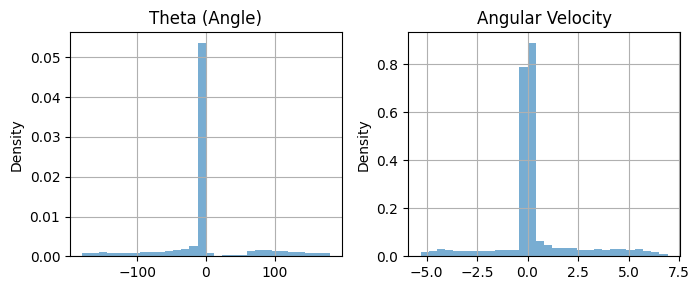

In [14]:
# TODO

## Render the learned policy

In [15]:
from IPython.display import Video, display
import cv2

def render_pendulum(agent):
    num_timesteps = 200
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    state, _ = env.reset()
    video_path = "PPO_render.mp4"
    frame_width, frame_height = env.render().shape[1], env.render().shape[0]
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(video_path, fourcc, 30, (frame_width, frame_height))
    for _ in range(num_timesteps):
        # action = env.action_space.sample()
        action = agent.choose_action(state).numpy()
        state, reward, done, _, _ = env.step(action)
        frame = env.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
        out.write(frame_bgr)
    out.release()
    env.close()
    display(Video(video_path))

render_pendulum(ppo)